In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
data = pd.read_csv("processed.csv")
data = data.drop("Unnamed: 0", axis=1)
data.head()

,SESSION_TYPE,TRACK_ID,WEATHER_0,TRACK_TEMPERATURE_0,AIR_TEMPERATURE_0,TRACK_TEMPERATURE_CHANGE_0,AIR_TEMPERATURE_CHANGE_0,RAIN_PERCENTAGE_0,WEATHER_5,TRACK_TEMPERATURE_5,...,AIR_TEMPERATURE_90,TRACK_TEMPERATURE_CHANGE_90,AIR_TEMPERATURE_CHANGE_90,RAIN_PERCENTAGE_90,WEATHER_120,TRACK_TEMPERATURE_120,AIR_TEMPERATURE_120,TRACK_TEMPERATURE_CHANGE_120,AIR_TEMPERATURE_CHANGE_120,RAIN_PERCENTAGE_120
0,10.0,3.0,0.0,31.0,25.0,2.0,2.0,2.0,0.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,3.0,0.0,31.0,25.0,2.0,2.0,2.0,0.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,3.0,0.0,31.0,25.0,2.0,2.0,2.0,0.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,3.0,0.0,31.0,25.0,2.0,2.0,2.0,0.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,3.0,0.0,31.0,25.0,2.0,2.0,2.0,0.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
time_windows={
    5 : [(0,5),(5,10),(10,15)],
    10 : [(0,10),(5,15)],
    15 : [(0,15),(15,30)],
    30 : [(0,30),(30,60), (60,90), (90,120)],
    60 : [(0,60),(60,120)]
}
single_val_cols = ['SESSION_TYPE', 'TRACK_ID']
multi_val_cols = ['AIR_TEMPERATURE_CHANGE',
 'TRACK_TEMPERATURE',
 'WEATHER',
 'RAIN_PERCENTAGE',
 'TRACK_TEMPERATURE_CHANGE',
 'AIR_TEMPERATURE']

In [24]:
def create_dataset(time_offset):
    rows = []
    columns = single_val_cols + multi_val_cols + ["TARGET"]
    windows = time_windows[time_offset]
    for i in tqdm(range(len(data))):
        cur_row = data.iloc[i]
        for w in windows:
            tmp_cols = single_val_cols + [f"{c}_{w[0]}" for c in multi_val_cols] + [f"WEATHER_{w[1]}"]
            if sum(cur_row[tmp_cols].isna()) == 0:
                rows.append(np.array(cur_row[tmp_cols]))
    df = pd.DataFrame(columns = columns, data=np.array(rows))
    return df

In [25]:
df_5_min = create_dataset(5)

100%|██████████| 104964/104964 [04:51<00:00, 360.31it/s]


In [26]:
df_5_min.to_csv("processed_5min.csv")

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

X = df_5_min.drop(["WEATHER", "TARGET"], axis=1)
y = df_5_min["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Train Acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test F1: {}".format(f1_score(y_test, y_pred_test, average=None)))



        SESSION_TYPE  TRACK_ID  AIR_TEMPERATURE_CHANGE  TRACK_TEMPERATURE  \
0               10.0       3.0                     2.0               31.0   
1               10.0       3.0                     2.0               31.0   
2               10.0       3.0                     2.0               31.0   
3               10.0       3.0                     2.0               31.0   
4               10.0       3.0                     2.0               31.0   
...              ...       ...                     ...                ...   
292576           8.0      28.0                     2.0               33.0   
292577           8.0      28.0                     2.0               33.0   
292578          10.0      28.0                     2.0               33.0   
292579          10.0      28.0                     2.0               33.0   
292580          10.0      28.0                     2.0               33.0   

        RAIN_PERCENTAGE  TRACK_TEMPERATURE_CHANGE  AIR_TEMPERATURE  
0     

In [32]:
print("Test Acc: {}".format(accuracy_score(y_test, X_test["WEATHER"])))
print("Test F1: {}".format(f1_score(y_test, X_test["WEATHER"], average=None)))

Test Acc: 0.9609344293111404
Test F1: [0.9781171  0.92253354 0.86684701 0.87804878]


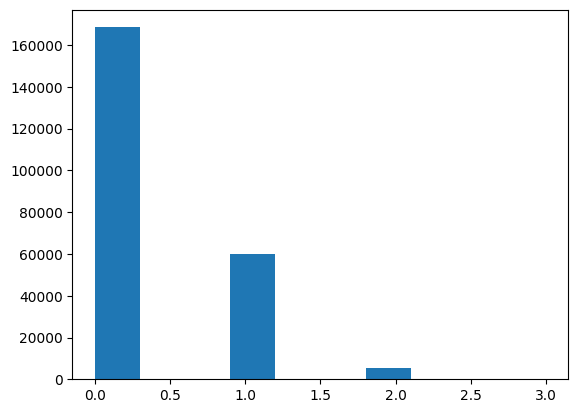

In [35]:
import matplotlib.pyplot as plt
plt.hist(y_train)
plt.show()

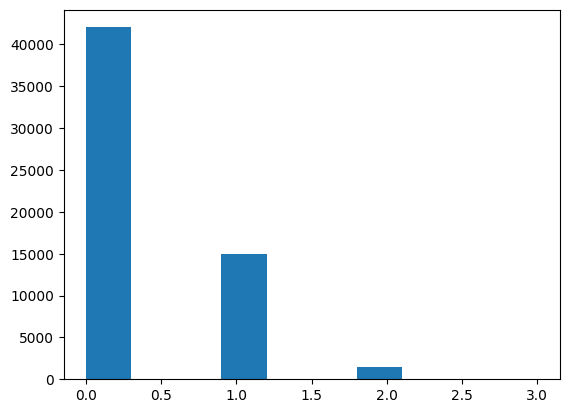

In [36]:
plt.hist(y_test)
plt.show()

In [38]:
set(y_test)

{0.0, 1.0, 2.0, 3.0}